## Reuters News 다중 분류 - LSTM
- 데이터 탐색

In [ ]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from tensorflow.keras.datasets import reuters

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data()
len(X_train), len(X_test)

2110848/2110848 [==============================] - 0s 0us/step


(8982, 2246)

In [ ]:
# 카테고리 개수
max(y_train) + 1 # 0부터 세기 때문에 +1

46

In [ ]:
# 첫 번째 뉴스 데이터
print(X_train[0])

[1, 27595, 28842, 8, 43, 10, 447, 5, 25, 207, 270, 5, 3095, 111, 16, 369, 186, 90, 67, 7, 89, 5, 19, 102, 6, 19, 124, 15, 90, 67, 84, 22, 482, 26, 7, 48, 4, 49, 8, 864, 39, 209, 154, 6, 151, 6, 83, 11, 15, 22, 155, 11, 15, 7, 48, 9, 4579, 1005, 504, 6, 258, 6, 272, 11, 15, 22, 134, 44, 11, 15, 16, 8, 197, 1245, 90, 67, 52, 29, 209, 30, 32, 132, 6, 109, 15, 17, 12]


In [ ]:
type(reuters.get_word_index())

550378/550378 [==============================] - 0s 0us/step


dict

In [ ]:
reuters.get_word_index()['the']

1

In [ ]:
index_word = {}
for key, value in reuters.get_word_index().items():
    index_word[value] = key
len(index_word)

30979

In [ ]:
# 첫 번째 기사 복원
' '.join(index_word[index] for index in X_train[0]) # 해당 단어가 어휘 사전에 없을 경우 0으로 처리

'the wattie nondiscriminatory mln loss for plc said at only ended said commonwealth could 1 traders now april 0 a after said from 1985 and from foreign 000 april 0 prices its account year a but in this mln home an states earlier and rise and revs vs 000 its 16 vs 000 a but 3 psbr oils several and shareholders and dividend vs 000 its all 4 vs 000 1 mln agreed largely april 0 are 2 states will billion total and against 000 pct dlrs'

In [ ]:
# 뉴스 기사의 최대/평균 길이
max(len(s) for s in X_train), sum(map(len, X_train)) / len(X_train)

(2376, 145.5398574927633)

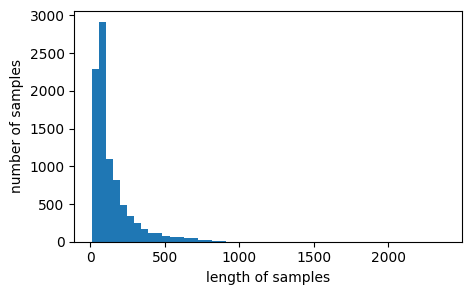

In [ ]:
# 뉴스 기사 단어수의 분포
plt.figure(figsize=(5,3))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of samples'), plt.ylabel('number of samples')
plt.show()

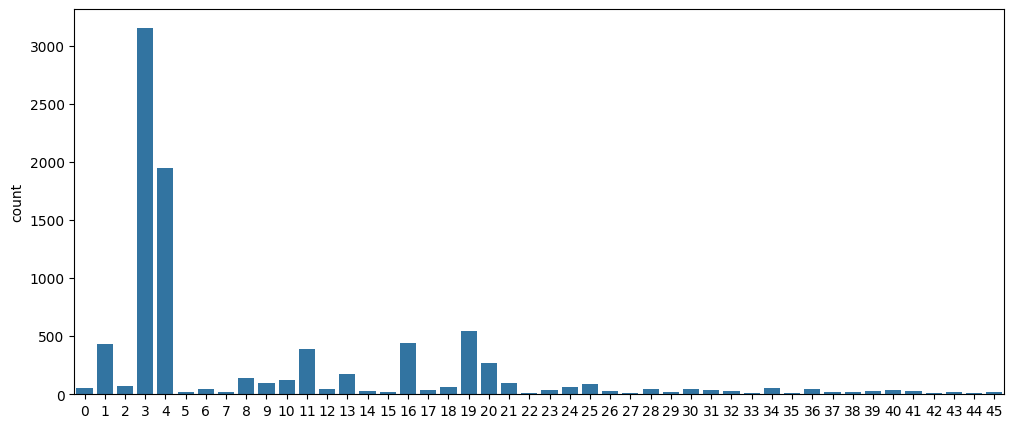

In [ ]:
# 뉴스 그룹의 분포
plt.figure(figsize=(12,5))
sns.countplot(x=y_train);

#### LSTM으로 뉴스 분류
- 문장 길이: 120 단어 (최대: 2,376, 평균: 146)
- 단어: 빈도수 기준 3,000 단어 (총 단어수: 30,979)

In [ ]:
max_words = 3000 # 최대 단어 개수를 3000개로 제한
max_len = 120

In [ ]:
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=max_words, test_split=0.2
)
len(X_train), len(X_test)

(8982, 2246)

In [ ]:
import tensorflow as tf
seed = 2023
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences # 시퀀스 데이터를 패딩하여 모든 시퀀스의 길이를 동일하게
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

In [ ]:
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 120), (2246, 120), (8982, 46), (2246, 46))

- 모델
    - Embedding vector length: 64
    - LSTM unit 개수: 100

In [ ]:
# 3000개의 단어를 64차원으로 임베딩. many-to-one 구조를 갖는 모델

model = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    LSTM(100), # dropout=0.2
    Dense(46, activation='softmax') # 다중 분류 문제이므로 softmax
])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 120, 64)           192000    
                                                                 
 lstm (LSTM)                 (None, 100)               66000     
                                                                 
 dense (Dense)               (None, 46)                4646      
                                                                 
Total params: 262646 (1.00 MB)
Trainable params: 262646 (1.00 MB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
model.compile('adam', 'categorical_crossentropy', ['accuracy'])
# 모듈 Adam 하이퍼파라미터 / RMSprop / Momentum
model_path = 'best-reuters-lstm.h5' # 모델의 가중치를 저장할 파일 경로 지정
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10) # 검증 손실이 10번의 에포크 동안 감소하지 않으면 조기 종료

In [ ]:
hist = model.fit(
    X_train, Y_train, validation_split=0.2, verbose=0,
    epochs=100, batch_size=128, callbacks=[mc,es]
)

# verbose=0: 훈련 과정의 출력을 화면에 표시하지 않음
# 콜백: 특정 이벤트가 발생할 때 호출되는 함수로, 모델 훈련 도중에 추가적인 동작을 수행하도록 도와줌
# mc: 모델 체크포인트 콜백, es: 조기 종료 콜백


Epoch 1: val_loss improved from inf to 2.41968, saving model to best-reuters-lstm.h5


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Epoch 2: val_loss improved from 2.41968 to 2.24931, saving model to best-reuters-lstm.h5

Epoch 3: val_loss improved from 2.24931 to 2.02781, saving model to best-reuters-lstm.h5

Epoch 4: val_loss improved from 2.02781 to 1.86970, saving model to best-reuters-lstm.h5

Epoch 5: val_loss improved from 1.86970 to 1.77761, saving model to best-reuters-lstm.h5

Epoch 6: val_loss improved from 1.77761 to 1.77549, saving model to best-reuters-lstm.h5

Epoch 7: val_loss did not improve from 1.77549

Epoch 8: val_loss improved from 1.77549 to 1.65448, saving model to best-reuters-lstm.h5

Epoch 9: val_loss improved from 1.65448 to 1.59154, saving model to best-reuters-lstm.h5

Epoch 10: val_loss improved from 1.59154 to 1.56554, saving model to best-reuters-lstm.h5

Epoch 11: val_loss improved from 1.56554 to 1.48861, saving model to best-reuters-lstm.h5

Epoch 12: val_loss improved from 1.48861 to 1.45169, saving model to best-reuters-lstm.h5

Epoch 13: val_loss did not improve from 1.45169


In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 7ms/step - loss: 1.4390 - accuracy: 0.6714


[1.4389936923980713, 0.6714158654212952]

#### LSTM으로 뉴스 분류 Ver.2
- 문장 길이: 100 단어 (최대: 2,376, 평균: 146)
- 단어: 빈도수 기준 1,000 단어 (총 단어수: 30,979)

In [ ]:
max_words = 1000
max_len = 100
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=max_words, test_split=0.2
)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

((8982, 100), (2246, 100), (8982, 46), (2246, 46))

In [ ]:
model2 = Sequential([
    Embedding(max_words, 64, input_length=max_len), # 입력 시퀀스를 받아 각 단어를 64차원으로 임베딩
    LSTM(100),
    Dense(46, activation='softmax') # 다중 클래스 분류를 위한 'Dense' 출력 레이어 추가
])

model2.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = 'best-reuters-lstm-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

hist2 = model2.fit(
    X_train, Y_train, validation_split=0.2, verbose=0,
    epochs=100, batch_size=128, callbacks=[mc,es]
)

# LSTM(Long Short-Term Memory): 순차적인 데이터를 처리하는 데 효과적인 순환 신경망(RNN)의 한 종류로서
# 장기 의존성(Long-Term Dependencies)을 효과적으로 학습할 수 있는 구조를 가지고 있음


Epoch 1: val_loss improved from inf to 2.41430, saving model to best-reuters-lstm-v2.h5

Epoch 2: val_loss improved from 2.41430 to 2.18538, saving model to best-reuters-lstm-v2.h5

Epoch 3: val_loss improved from 2.18538 to 2.04030, saving model to best-reuters-lstm-v2.h5

Epoch 4: val_loss improved from 2.04030 to 1.96955, saving model to best-reuters-lstm-v2.h5

Epoch 5: val_loss improved from 1.96955 to 1.85827, saving model to best-reuters-lstm-v2.h5

Epoch 6: val_loss improved from 1.85827 to 1.76884, saving model to best-reuters-lstm-v2.h5

Epoch 7: val_loss did not improve from 1.76884

Epoch 8: val_loss improved from 1.76884 to 1.61598, saving model to best-reuters-lstm-v2.h5

Epoch 9: val_loss improved from 1.61598 to 1.53290, saving model to best-reuters-lstm-v2.h5

Epoch 10: val_loss did not improve from 1.53290

Epoch 11: val_loss improved from 1.53290 to 1.50378, saving model to best-reuters-lstm-v2.h5

Epoch 12: val_loss improved from 1.50378 to 1.41658, saving model to

In [ ]:
# Dropout 추가
# 훈련 과정에서 무작위로 선택된 일부 뉴런을 제거하여 네트워크의 일부를 무작위로 비활성화 => 과적합을 줄이고 일반화 성능을 향상
# 0.2에서 0.5 사이의 값, 완전 연결 레이어나 LSTM, GRU와 같은 순환 레이어에 적용하는 것이 효과적

from tensorflow.keras.layers import Dorpout

model12 = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    LSTM(100),
    Dropout(0.2),
    Dense(46, activation='softmax')
])

model12.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = 'best-reuters-lstm-v2.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

hist2 = model.fit(
    X_train, Y_train, validation_split=0.2, verbose=0,
    epochs=100, batch_size=128, callbacks=[mc, es]
)

In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 6ms/step - loss: 1.3039 - accuracy: 0.6839


[1.3038889169692993, 0.683882474899292]

#### LSTM으로 뉴스 분류 Ver.3
- 문장 길이: 150 단어 (최대: 2,376, 평균: 146)
- 단어: 빈도수 기준 5,000 단어 (총 단어수: 30,979)

In [ ]:
max_words = 5000 # 가장 빈도가 높은 5000개의 단어만 사용
max_len = 150
(X_train, y_train), (X_test, y_test) = reuters.load_data(
    num_words=max_words, test_split=0.2
)
X_train = pad_sequences(X_train, maxlen=max_len)
X_test = pad_sequences(X_test, maxlen=max_len)
Y_train = to_categorical(y_train)
Y_test = to_categorical(y_test)
X_train.shape, X_test.shape, Y_train.shape, Y_test.shape

# pad_sequences(): 시퀀스 데이터를 패딩하여 길이를 일관되게. 'max_len'으로 지정된 길이로 모든 시퀀스를 패딩
# to_categorical(): 라벨 데이터를 원-핫 인코딩 형식으로 변환. 다중 클래스 분류 문제에서 사용되며, 각 클래스를 이진 벡터로 표현

((8982, 150), (2246, 150), (8982, 46), (2246, 46))

In [ ]:
model3 = Sequential([
    Embedding(max_words, 64, input_length=max_len),
    LSTM(100),
    Dense(46, activation='softmax')
])

# 옵티마이저 'adam', 손실 함수 'categorical_crossentropy', 모니터링할 지표 'accuracy'
model3.compile('adam', 'categorical_crossentropy', ['accuracy'])

model_path = 'best-reuters-lstm-v3.h5'
mc = ModelCheckpoint(model_path, save_best_only=True, verbose=1)
es = EarlyStopping(patience=10)

hist3 = model3.fit(
    X_train, Y_train, validation_split=0.2, verbose=0,
    epochs=100, batch_size=128, callbacks=[mc,es]
)


Epoch 1: val_loss improved from inf to 2.41642, saving model to best-reuters-lstm-v3.h5

Epoch 2: val_loss improved from 2.41642 to 2.38796, saving model to best-reuters-lstm-v3.h5

Epoch 3: val_loss improved from 2.38796 to 1.93935, saving model to best-reuters-lstm-v3.h5

Epoch 4: val_loss improved from 1.93935 to 1.79174, saving model to best-reuters-lstm-v3.h5

Epoch 5: val_loss improved from 1.79174 to 1.64700, saving model to best-reuters-lstm-v3.h5

Epoch 6: val_loss did not improve from 1.64700

Epoch 7: val_loss did not improve from 1.64700

Epoch 8: val_loss improved from 1.64700 to 1.61761, saving model to best-reuters-lstm-v3.h5

Epoch 9: val_loss improved from 1.61761 to 1.60052, saving model to best-reuters-lstm-v3.h5

Epoch 10: val_loss improved from 1.60052 to 1.54675, saving model to best-reuters-lstm-v3.h5

Epoch 11: val_loss improved from 1.54675 to 1.50058, saving model to best-reuters-lstm-v3.h5

Epoch 12: val_loss improved from 1.50058 to 1.48901, saving model to

In [ ]:
best_model = load_model(model_path)
best_model.evaluate(X_test, Y_test)

71/71 [==============================] - 1s 4ms/step - loss: 1.5306 - accuracy: 0.6362


[1.5305745601654053, 0.6362422108650208]

- 결과 비교

In [ ]:
import pandas as pd
num_words = [100, 120, 150] # 어휘 사전에 있는 단어 수
words_per_article = [1000, 3000, 5000] # 각 기사에 포함된 평균 단어 수
num_embed = [64, 64, 64] # 단어를 나타내는 임베당 벡터의 차원 수
num_units = [100, 100, 100] # LSTM 레이어에 있는 유닛(뉴런)의 수
acc = [0.6683, 0.6456, 0.6465] # 각 실험에서 얻은 모델의 정확도
df = pd.DataFrame({
    '고유단어수':num_words, '기사당 단어수':words_per_article, '임베딩 벡터':num_embed,
    'LSTM 유닛':num_units, '정확도':acc
})
df

,고유단어수,기사당 단어수,임베딩 벡터,LSTM 유닛,정확도
0,100,1000,64,100,0.6683
1,120,3000,64,100,0.6456
2,150,5000,64,100,0.6465
